<a href="https://colab.research.google.com/github/nikhil0209/Inititalization-Effects-on-Recommenders/blob/main/graph_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting my local drive to google colab accessible disk storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copying stochastic.py to be able to import it. Contains the graph aligment functions.
!cp "/content/drive/MyDrive/initialization_experiments_collaborative_filtering/stochasticcopy.py" .
!cp "/content/drive/MyDrive/Colab Notebooks/randomized_box_algorithm.py" .

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import torch
from tqdm import trange
import matplotlib.pyplot as plt
import networkx as nx
from stochasticcopy import *
import time
import pickle
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import Module, Parameter
from scipy.sparse import coo_matrix
import scipy.stats
import importlib
import sys
import random
import matplotlib.animation as animation
from randomized_box_algorithm import *

In [ ]:
#This function return the k closest items to point from the neighbours list
def knnIndices(point, neighbours, k):
  distances = []
  for neighbour in neighbours:
    distances.append(np.linalg.norm(point - neighbour))
  return np.argsort(np.array(distances)).tolist()[:k]

In [ ]:
def topKDotProds(point, neighbours, k):
  dot_prods = []
  for neighbour in neighbours:
    dot_prods.append(np.dot(point, neighbour))
  return np.argsort(np.array(dot_prods)).tolist()[-k:]

In [ ]:
# This is the Neural Network class of pytorch which helps in adjusting the features of users and movies so that their dot products are as close to the original movie-user matrix
class PMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
    
    def forward(self, matrix, u_features, v_features, non_zero_mask):
        predicted = torch.sigmoid(torch.matmul(u_features, v_features.t()))
        
        diff = (matrix - predicted)**2
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * torch.sum(u_features.norm(dim=1))
        v_regularization = self.lam_v * torch.sum(v_features.norm(dim=1))
        
        return prediction_error + u_regularization + v_regularization

In [ ]:
# This calculates the laplacian matrix of the given graph
def find_laplacian(G):
    isolated_nodes = list(nx.isolates(G))
    print("Number of isolated nodes", len(isolated_nodes))
    # G.remove_nodes_from(isolated_nodes) # removing 0 degree nodes from the graph
    for node in isolated_nodes:
        while True:
            x = round(np.random.uniform(0, n_users))
            temp = list(G)
            if x in temp:
                G.add_edge(x, node)
                break
    n = len(G)
    print("Length of graph " + str(n) + "\n")
    l1 = nx.laplacian_matrix(G, range(n))
    print("Shape of L1 is" + str(l1.shape) + "\n")
    l1 = np.array(l1.todense())
    print("Shape of L1 after densifying " + str(l1.shape) + "\n")
    sbm_G = np.double(l1)
    print("Length of laplacian is " +  str(sbm_G.shape) + "\n")
    return sbm_G

In [ ]:
# Return the elements of list1 which are not present in list2
def Diff(li1, li2):
    return list(set(li1) - set(li2))

In [ ]:
# Some hyperparameters along with numbers of users and number of movies
latent_vectors = 90
graph_alignment_epochs = 600
num_epochs = 10000
n_users = 100
n_movies = 40
k = 20

In [ ]:
# Initiating the features randomly
user_features = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
connectivity_matrix = np.zeros((n_users, n_movies))
# forming edges to the k closest movies 
for i in range(n_users):
  knn_indices = knnIndices(user_features[i], movie_features, k)
  for idx in knn_indices:
    connectivity_matrix[i, idx] = 1
print("Shape of conncectivty_matirx is", connectivity_matrix.shape)

# Converting the U x I matrix to a N x N matrix where N = U + I. This is the full adjacency matrix of the graph
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = connectivity_matrix
lower_left_matrix = np.transpose(connectivity_matrix)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix = np.concatenate((upper_matrix, lower_matrix), axis=0)
original_graph = nx.from_numpy_array(adjacency_matrix)

In [ ]:
# calculating the dot product of all movie user combinations and storing them in a matrix
dot_product_matrix = user_features @ movie_features.T

In [ ]:
# converting the scores to softmax probabilities
exp_matrix = np.exp(dot_product_matrix)
movie_user_softmax = exp_matrix/np.tile(np.reshape(np.sum(exp_matrix, axis=1), (n_users, 1)), (1, n_movies))
movie_user_hardmax = movie_user_softmax

In [ ]:
# Choosing top k movie scores as edges and not forming edges with other movies
for i in range(movie_user_softmax.shape[0]):
  top_k_movies = np.argsort(movie_user_softmax[i, :]).tolist()[-k:]
  for movie in top_k_movies:
    movie_user_hardmax[i, movie] = 1
  not_top_k_movies = Diff([i for i in range(n_movies)], top_k_movies)
  for movie in not_top_k_movies:
    movie_user_hardmax[i, movie] = 0

In [ ]:
# Forming a full N x N matrix from U x I matrix (full adjacency matrix)
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = movie_user_hardmax
lower_left_matrix = np.transpose(movie_user_hardmax)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix = np.concatenate((upper_matrix, lower_matrix), axis=0)
predicted_graph = nx.from_numpy_array(adjacency_matrix)

In [ ]:
# Finding the laplacian of the two graphs
sbm_g = find_laplacian(original_graph)
sbm_g1 = find_laplacian(predicted_graph)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)



[Epoch    1/600] loss: 10.585695 - std: 9.740947
[Epoch  100/600] loss: 5.465794 - std: 5.727776
[Epoch  200/600] loss: 4.436864 - std: 5.172337
[Epoch  300/600] loss: 4.866155 - std: 4.828507
[Epoch  400/600] loss: 4.479926 - std: 4.559096
[Epoch  500/600] loss: 4.283256 - std: 4.343044
[Epoch  600/600] loss: 4.420208 - std: 4.179828


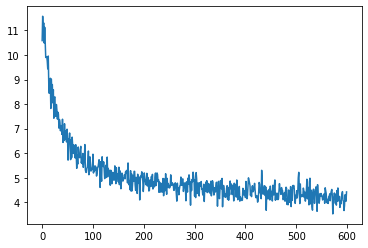


100%|██████████| 100/100 [00:00<00:00, 116.10it/s, loss=107.580]



Total time taken for 100 iterations is 16.43417739868164 (s)


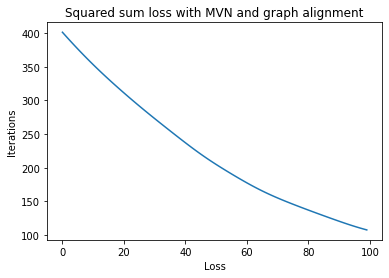

In [ ]:
# Aligning the two graphs
start_time = time.time()
sbm_G_inv, sbm_G1_inv, sbm_P = find_permutation(sbm_g, sbm_g1, it=10, tau=2, n_samples=k, epochs=graph_alignment_epochs, lr=0.5, 
                                               loss_type = 'w', alpha = 0.1, ones = True)

permutation = []
for i in range(sbm_P.shape[0]):
    for j in range(sbm_P.shape[1]):
        if sbm_P[i][j] == 1:
            permutation.append(j)

# Permuting the features assuming that movies and users are aligned among themselves and not across the two sets.
permuted_indices = permutation[0:n_users]
permuted_indices_shifted = [i%n_users for i in permuted_indices]
user_features_p = user_features[permuted_indices_shifted, :]
permuted_indices = permutation[n_users:n_users+n_movies]
permuted_indices_shifted = [i%n_movies for i in permuted_indices]
movie_features_p = movie_features[permuted_indices_shifted, :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_p = torch.FloatTensor(user_features_p).to(device)
movie_features_p = torch.FloatTensor(movie_features_p).to(device)
user_features_p.requires_grad = True
movie_features_p.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_p, movie_features_p], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_p, movie_features_p, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with MVN and graph alignment')
plt.show()

  1%|          | 121/10000 [00:01<01:29, 110.04it/s, loss=1,248.709]

The mean average precision for 99 epochs is 0.6417510913213894


  2%|▏         | 227/10000 [00:02<01:23, 117.65it/s, loss=1,138.912]

The mean average precision for 199 epochs is 0.6795913535832075


  3%|▎         | 321/10000 [00:02<01:24, 114.57it/s, loss=1,027.839]

The mean average precision for 299 epochs is 0.7127901564401374


  4%|▍         | 425/10000 [00:03<01:24, 113.00it/s, loss=922.357]

The mean average precision for 399 epochs is 0.7384141336776398


  5%|▌         | 524/10000 [00:04<01:30, 105.04it/s, loss=802.314]

The mean average precision for 499 epochs is 0.777677890960089


  6%|▋         | 626/10000 [00:05<01:20, 116.50it/s, loss=673.596]

The mean average precision for 599 epochs is 0.8157497088244573


  7%|▋         | 719/10000 [00:06<01:21, 113.59it/s, loss=530.694]

The mean average precision for 699 epochs is 0.8537515430411521


  8%|▊         | 825/10000 [00:07<01:20, 113.31it/s, loss=386.449]

The mean average precision for 799 epochs is 0.906163242150007


  9%|▉         | 916/10000 [00:07<01:18, 116.23it/s, loss=266.233]

The mean average precision for 899 epochs is 0.9378964343920618


 10%|█         | 1025/10000 [00:08<01:17, 115.90it/s, loss=169.680]

The mean average precision for 999 epochs is 0.9604896093586497


 11%|█         | 1120/10000 [00:09<01:18, 112.49it/s, loss=104.009]

The mean average precision for 1099 epochs is 0.9823180343327986


 12%|█▏        | 1216/10000 [00:10<01:15, 116.55it/s, loss=59.178]

The mean average precision for 1199 epochs is 0.9948095943422764


 13%|█▎        | 1319/10000 [00:11<01:17, 112.33it/s, loss=41.352]

The mean average precision for 1299 epochs is 0.9993177968380949


 14%|█▍        | 1426/10000 [00:11<01:17, 109.99it/s, loss=34.409]

Time taken to reach mAP of 1 is 11.964829921722412
The mean average precision for 1399 epochs is 1.0


 15%|█▌        | 1520/10000 [00:12<01:24, 99.79it/s, loss=31.835]

The mean average precision for 1499 epochs is 1.0


 16%|█▌        | 1623/10000 [00:13<01:15, 110.85it/s, loss=30.826]

The mean average precision for 1599 epochs is 1.0


 17%|█▋        | 1716/10000 [00:14<01:12, 114.21it/s, loss=30.507]

The mean average precision for 1699 epochs is 1.0


 18%|█▊        | 1815/10000 [00:15<01:09, 117.12it/s, loss=30.403]

The mean average precision for 1799 epochs is 1.0


 19%|█▉        | 1921/10000 [00:16<01:11, 112.51it/s, loss=30.359]

The mean average precision for 1899 epochs is 1.0


 20%|██        | 2021/10000 [00:16<01:11, 111.85it/s, loss=30.339]

The mean average precision for 1999 epochs is 1.0


 21%|██▏       | 2128/10000 [00:17<01:06, 117.90it/s, loss=30.330]

The mean average precision for 2099 epochs is 1.0


 22%|██▏       | 2215/10000 [00:18<01:13, 106.24it/s, loss=30.325]

The mean average precision for 2199 epochs is 1.0


 23%|██▎       | 2317/10000 [00:19<01:09, 110.86it/s, loss=30.322]

The mean average precision for 2299 epochs is 1.0


 24%|██▍       | 2419/10000 [00:20<01:12, 105.19it/s, loss=30.320]

The mean average precision for 2399 epochs is 1.0


 25%|██▌       | 2525/10000 [00:21<01:01, 120.67it/s, loss=30.319]

The mean average precision for 2499 epochs is 1.0


 26%|██▌       | 2618/10000 [00:21<01:02, 118.49it/s, loss=30.319]

The mean average precision for 2599 epochs is 1.0


 27%|██▋       | 2725/10000 [00:22<01:06, 109.43it/s, loss=30.318]

The mean average precision for 2699 epochs is 1.0


 28%|██▊       | 2827/10000 [00:23<01:04, 110.88it/s, loss=30.318]

The mean average precision for 2799 epochs is 1.0


 29%|██▉       | 2916/10000 [00:24<01:01, 115.19it/s, loss=30.318]

The mean average precision for 2899 epochs is 1.0


 30%|███       | 3020/10000 [00:25<01:00, 114.66it/s, loss=30.318]

The mean average precision for 2999 epochs is 1.0


 31%|███       | 3114/10000 [00:25<01:01, 111.92it/s, loss=30.318]

The mean average precision for 3099 epochs is 1.0


 32%|███▏      | 3216/10000 [00:26<01:02, 107.99it/s, loss=30.318]

The mean average precision for 3199 epochs is 1.0


 33%|███▎      | 3315/10000 [00:27<01:03, 105.47it/s, loss=30.318]

The mean average precision for 3299 epochs is 1.0


 34%|███▍      | 3422/10000 [00:28<00:58, 112.60it/s, loss=30.318]

The mean average precision for 3399 epochs is 1.0


 35%|███▌      | 3521/10000 [00:29<01:00, 107.89it/s, loss=30.318]

The mean average precision for 3499 epochs is 1.0


 36%|███▌      | 3616/10000 [00:30<01:02, 102.22it/s, loss=30.318]

The mean average precision for 3599 epochs is 1.0


 37%|███▋      | 3727/10000 [00:30<00:54, 114.21it/s, loss=30.318]

The mean average precision for 3699 epochs is 1.0


 38%|███▊      | 3822/10000 [00:31<00:53, 115.71it/s, loss=30.318]

The mean average precision for 3799 epochs is 1.0


 39%|███▉      | 3928/10000 [00:32<00:53, 113.75it/s, loss=30.318]

The mean average precision for 3899 epochs is 1.0


 40%|████      | 4021/10000 [00:33<00:50, 117.39it/s, loss=30.318]

The mean average precision for 3999 epochs is 1.0


 41%|████      | 4124/10000 [00:34<00:56, 104.06it/s, loss=30.318]

The mean average precision for 4099 epochs is 1.0


 42%|████▏     | 4227/10000 [00:35<00:52, 109.37it/s, loss=30.318]

The mean average precision for 4199 epochs is 1.0


 43%|████▎     | 4327/10000 [00:35<00:53, 106.79it/s, loss=30.318]

The mean average precision for 4299 epochs is 1.0


 44%|████▍     | 4415/10000 [00:36<00:52, 107.21it/s, loss=30.318]

The mean average precision for 4399 epochs is 1.0


 45%|████▌     | 4520/10000 [00:37<00:50, 108.90it/s, loss=30.318]

The mean average precision for 4499 epochs is 1.0


 46%|████▋     | 4625/10000 [00:38<00:47, 112.29it/s, loss=30.318]

The mean average precision for 4599 epochs is 1.0


 47%|████▋     | 4722/10000 [00:39<00:47, 112.18it/s, loss=30.318]

The mean average precision for 4699 epochs is 1.0


 48%|████▊     | 4818/10000 [00:40<00:42, 121.68it/s, loss=30.318]

The mean average precision for 4799 epochs is 1.0


 49%|████▉     | 4924/10000 [00:40<00:46, 109.00it/s, loss=30.318]

The mean average precision for 4899 epochs is 1.0


 50%|█████     | 5016/10000 [00:41<00:44, 110.91it/s, loss=30.318]

The mean average precision for 4999 epochs is 1.0


 51%|█████     | 5120/10000 [00:42<00:40, 119.11it/s, loss=30.318]

The mean average precision for 5099 epochs is 1.0


 52%|█████▏    | 5214/10000 [00:43<00:45, 106.01it/s, loss=30.318]

The mean average precision for 5199 epochs is 1.0


 53%|█████▎    | 5324/10000 [00:44<00:41, 113.67it/s, loss=30.318]

The mean average precision for 5299 epochs is 1.0


 54%|█████▍    | 5416/10000 [00:44<00:41, 109.26it/s, loss=30.318]

The mean average precision for 5399 epochs is 1.0


 55%|█████▌    | 5516/10000 [00:45<00:42, 105.42it/s, loss=30.318]

The mean average precision for 5499 epochs is 1.0


 56%|█████▌    | 5619/10000 [00:46<00:39, 112.02it/s, loss=30.318]

The mean average precision for 5599 epochs is 1.0


 57%|█████▋    | 5723/10000 [00:47<00:38, 111.55it/s, loss=30.318]

The mean average precision for 5699 epochs is 1.0


 58%|█████▊    | 5825/10000 [00:48<00:36, 115.71it/s, loss=30.318]

The mean average precision for 5799 epochs is 1.0


 59%|█████▉    | 5914/10000 [00:49<00:39, 103.70it/s, loss=30.318]

The mean average precision for 5899 epochs is 1.0


 60%|██████    | 6015/10000 [00:49<00:37, 107.09it/s, loss=30.318]

The mean average precision for 5999 epochs is 1.0


 61%|██████    | 6121/10000 [00:50<00:35, 108.27it/s, loss=30.318]

The mean average precision for 6099 epochs is 1.0


 62%|██████▏   | 6220/10000 [00:51<00:35, 105.25it/s, loss=30.318]

The mean average precision for 6199 epochs is 1.0


 63%|██████▎   | 6323/10000 [00:52<00:34, 106.50it/s, loss=30.318]

The mean average precision for 6299 epochs is 1.0


 64%|██████▍   | 6418/10000 [00:53<00:32, 111.08it/s, loss=30.318]

The mean average precision for 6399 epochs is 1.0


 65%|██████▌   | 6521/10000 [00:54<00:32, 108.69it/s, loss=30.318]

The mean average precision for 6499 epochs is 1.0


 66%|██████▌   | 6623/10000 [00:55<00:30, 110.06it/s, loss=30.318]

The mean average precision for 6599 epochs is 1.0


 67%|██████▋   | 6717/10000 [00:55<00:29, 112.60it/s, loss=30.318]

The mean average precision for 6699 epochs is 1.0


 68%|██████▊   | 6819/10000 [00:56<00:28, 109.86it/s, loss=30.318]

The mean average precision for 6799 epochs is 1.0


 69%|██████▉   | 6919/10000 [00:57<00:25, 119.05it/s, loss=30.318]

The mean average precision for 6899 epochs is 1.0


 70%|███████   | 7016/10000 [00:58<00:29, 102.67it/s, loss=30.318]

The mean average precision for 6999 epochs is 1.0


 71%|███████▏  | 7126/10000 [00:59<00:25, 111.84it/s, loss=30.318]

The mean average precision for 7099 epochs is 1.0


 72%|███████▏  | 7213/10000 [00:59<00:26, 105.46it/s, loss=30.318]

The mean average precision for 7199 epochs is 1.0


 73%|███████▎  | 7314/10000 [01:00<00:25, 104.18it/s, loss=30.318]

The mean average precision for 7299 epochs is 1.0


 74%|███████▍  | 7429/10000 [01:01<00:22, 115.57it/s, loss=30.318]

The mean average precision for 7399 epochs is 1.0


 75%|███████▌  | 7524/10000 [01:02<00:20, 120.18it/s, loss=30.318]

The mean average precision for 7499 epochs is 1.0


 76%|███████▌  | 7623/10000 [01:03<00:20, 115.01it/s, loss=30.318]

The mean average precision for 7599 epochs is 1.0


 77%|███████▋  | 7718/10000 [01:04<00:21, 108.59it/s, loss=30.318]

The mean average precision for 7699 epochs is 1.0


 78%|███████▊  | 7823/10000 [01:04<00:18, 117.32it/s, loss=30.318]

The mean average precision for 7799 epochs is 1.0


 79%|███████▉  | 7921/10000 [01:05<00:18, 115.30it/s, loss=30.318]

The mean average precision for 7899 epochs is 1.0


 80%|████████  | 8020/10000 [01:06<00:17, 113.66it/s, loss=30.318]

The mean average precision for 7999 epochs is 1.0


 81%|████████  | 8121/10000 [01:07<00:18, 103.57it/s, loss=30.318]

The mean average precision for 8099 epochs is 1.0


 82%|████████▏ | 8214/10000 [01:08<00:18, 97.48it/s, loss=30.318]

The mean average precision for 8199 epochs is 1.0


 83%|████████▎ | 8329/10000 [01:09<00:14, 116.36it/s, loss=30.318]

The mean average precision for 8299 epochs is 1.0


 84%|████████▍ | 8416/10000 [01:09<00:14, 111.28it/s, loss=30.318]

The mean average precision for 8399 epochs is 1.0


 85%|████████▌ | 8521/10000 [01:10<00:13, 106.18it/s, loss=30.318]

The mean average precision for 8499 epochs is 1.0


 86%|████████▌ | 8613/10000 [01:11<00:12, 108.10it/s, loss=30.318]

The mean average precision for 8599 epochs is 1.0


 87%|████████▋ | 8726/10000 [01:12<00:11, 107.53it/s, loss=30.318]

The mean average precision for 8699 epochs is 1.0


 88%|████████▊ | 8828/10000 [01:13<00:10, 110.92it/s, loss=30.318]

The mean average precision for 8799 epochs is 1.0


 89%|████████▉ | 8928/10000 [01:14<00:09, 110.57it/s, loss=30.318]

The mean average precision for 8899 epochs is 1.0


 90%|█████████ | 9013/10000 [01:14<00:09, 101.42it/s, loss=30.318]

The mean average precision for 8999 epochs is 1.0


 91%|█████████▏| 9125/10000 [01:15<00:08, 104.68it/s, loss=30.318]

The mean average precision for 9099 epochs is 1.0


 92%|█████████▏| 9221/10000 [01:16<00:07, 103.26it/s, loss=30.318]

The mean average precision for 9199 epochs is 1.0


 93%|█████████▎| 9322/10000 [01:17<00:06, 110.36it/s, loss=30.318]

The mean average precision for 9299 epochs is 1.0


 94%|█████████▍| 9423/10000 [01:18<00:05, 106.75it/s, loss=30.318]

The mean average precision for 9399 epochs is 1.0


 95%|█████████▌| 9515/10000 [01:19<00:04, 101.10it/s, loss=30.318]

The mean average precision for 9499 epochs is 1.0


 96%|█████████▌| 9618/10000 [01:20<00:03, 111.57it/s, loss=30.318]

The mean average precision for 9599 epochs is 1.0


 97%|█████████▋| 9725/10000 [01:21<00:02, 115.72it/s, loss=30.318]

The mean average precision for 9699 epochs is 1.0


 98%|█████████▊| 9819/10000 [01:21<00:01, 108.84it/s, loss=30.318]

The mean average precision for 9799 epochs is 1.0


 99%|█████████▉| 9918/10000 [01:22<00:00, 101.84it/s, loss=30.318]

The mean average precision for 9899 epochs is 1.0


100%|██████████| 10000/10000 [01:23<00:00, 119.89it/s, loss=30.318]


The mean average precision for 9999 epochs is 1.0

Total time taken for 10000 iterations is 83.68306231498718 (s)


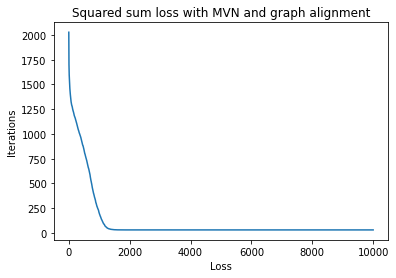

In [ ]:
# Using random initializations
start_time_1 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
user_features = torch.randn(n_users, 304, requires_grad=True, device=device)
movie_features = torch.randn(n_movies, 304, requires_grad=True, device=device)
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)

# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features, movie_features], lr=0.01)
is_one = False
bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features, movie_features, non_zero_mask)
    if epoch % 100 == 99:
      connectivity_matrix_1 = user_features.cpu().detach().numpy() @ movie_features.transpose(0, 1).cpu().detach().numpy()
      upper_left_matrix_1 = np.zeros((n_users, n_users))
      upper_right_matrix_1 = connectivity_matrix_1
      lower_left_matrix_1 = np.transpose(connectivity_matrix_1)
      lower_right_matrix_1 = np.zeros((n_movies, n_movies))
      upper_matrix_1 = np.concatenate((upper_left_matrix_1, upper_right_matrix_1), axis=1)
      lower_matrix_1 = np.concatenate((lower_left_matrix_1, lower_right_matrix_1), axis=1)
      adjacency_matrix_1 = np.concatenate((upper_matrix_1, lower_matrix_1), axis=0)
      mean_average_precision = mAP(adjacency_matrix_1, connectivity_matrix.cpu().detach().numpy(), k)
      if mean_average_precision == 1 and is_one == False:
        end_time_1 = time.time()
        is_one = True
        print("Time taken to reach mAP of 1 is", end_time_1 - start_time_1)
      print("The mean average precision for", epoch, "epochs is", mean_average_precision)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time_2 = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time_2 - start_time_1,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with MVN and graph alignment')
plt.show()

In [ ]:
'''
Forming the original graph using dot product instead of distance
'''
# Initiating the features randomly
user_features = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
connectivity_matrix = np.zeros((n_users, n_movies))
# forming edges to the k highes dot product movies 
for i in range(n_users):
  knn_indices = topKDotProds(user_features[i], movie_features, k)
  for idx in knn_indices:
    connectivity_matrix[i, idx] = 1
print("Shape of conncectivty_matirx is", connectivity_matrix.shape)

# Converting the U x I matrix to a N x N matrix where N = U + I. This is the full adjacency matrix of the graph
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = connectivity_matrix
lower_left_matrix = np.transpose(connectivity_matrix)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix = np.concatenate((upper_matrix, lower_matrix), axis=0)
original_graph = nx.from_numpy_array(adjacency_matrix)

Shape of conncectivty_matirx is (100, 10)


In [ ]:
# calculating the dot product of all movie user combinations and storing them in a matrix
dot_product_matrix = user_features @ movie_features.T

In [ ]:
# converting the scores to softmax probabilities
exp_matrix = np.exp(dot_product_matrix)
movie_user_softmax = exp_matrix/np.tile(np.reshape(np.sum(exp_matrix, axis=1), (n_users, 1)), (1, n_movies))
movie_user_hardmax = movie_user_softmax

In [ ]:
# Choosing top k movie scores as edges and not forming edges with other movies
for i in range(dot_product_matrix.shape[0]):
  top_k_movies = np.argsort(dot_product_matrix[i, :]).tolist()[-k:]
  for movie in top_k_movies:
    movie_user_hardmax[i, movie] = 1
  not_top_k_movies = Diff([i for i in range(n_movies)], top_k_movies)
  for movie in not_top_k_movies:
    movie_user_hardmax[i, movie] = 0

In [ ]:
# Choosing top k movie scores as edges and not forming edges with other movies
for i in range(movie_user_softmax.shape[0]):
  top_k_movies = np.argsort(movie_user_softmax[i, :]).tolist()[-k:]
  for movie in top_k_movies:
    movie_user_hardmax[i, movie] = 1
  not_top_k_movies = Diff([i for i in range(n_movies)], top_k_movies)
  for movie in not_top_k_movies:
    movie_user_hardmax[i, movie] = 0

In [ ]:
# Forming a full N x N matrix from U x I matrix (full adjacency matrix)
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = movie_user_hardmax
lower_left_matrix = np.transpose(movie_user_hardmax)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix_1 = np.concatenate((upper_matrix, lower_matrix), axis=0)
predicted_graph = nx.from_numpy_array(adjacency_matrix_1)

In [ ]:
# Finding the laplacian of the two graphs
sbm_g = find_laplacian(original_graph)
sbm_g1 = find_laplacian(predicted_graph)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)



[Epoch    1/600] loss: 10.578701 - std: 9.748900
[Epoch  100/600] loss: 5.842093 - std: 5.775603
[Epoch  200/600] loss: 4.595595 - std: 5.254131
[Epoch  300/600] loss: 4.541889 - std: 4.927065
[Epoch  400/600] loss: 4.471151 - std: 4.654711
[Epoch  500/600] loss: 4.236334 - std: 4.415193
[Epoch  600/600] loss: 3.814388 - std: 4.212189


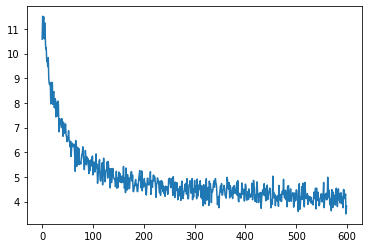

In [ ]:
# Aligning the two graphs
start_time = time.time()
sbm_G_inv, sbm_G1_inv, sbm_P = find_permutation(sbm_g, sbm_g1, it=10, tau=2, n_samples=k, epochs=graph_alignment_epochs, lr=0.5, 
                                               loss_type = 'w', alpha = 0.1, ones = True)

permutation = []
for i in range(sbm_P.shape[0]):
    for j in range(sbm_P.shape[1]):
        if sbm_P[i][j] == 1:
            permutation.append(j)

# Permuting the features assuming that movies and users are aligned among themselves and not across the two sets.

In [ ]:
print(permutation)

[22, 6, 86, 68, 1, 52, 84, 32, 78, 85, 15, 89, 33, 63, 49, 48, 28, 9, 40, 44, 99, 2, 21, 45, 41, 29, 79, 50, 43, 37, 74, 26, 53, 76, 75, 30, 3, 31, 35, 23, 77, 73, 0, 95, 80, 12, 70, 39, 7, 88, 94, 69, 72, 92, 60, 57, 83, 90, 71, 36, 66, 13, 65, 69, 27, 8, 5, 97, 64, 88, 54, 47, 51, 41, 17, 25, 91, 16, 4, 55, 38, 82, 10, 46, 34, 24, 20, 14, 18, 93, 11, 67, 62, 56, 61, 42, 58, 59, 81, 19, 104, 100, 109, 107, 108, 102, 103, 105, 101, 106]


100%|██████████| 100/100 [00:00<00:00, 234.11it/s, loss=41.002]



Total time taken for 100 iterations is 0.43335390090942383 (s)


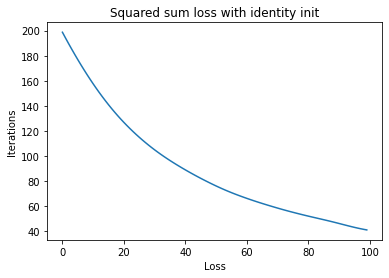

In [ ]:
start_time = time.time()
permutation = [i for i in range(n_users + n_movies)]
permuted_indices = permutation[0:n_users]
permuted_indices_shifted = [i%n_users for i in permuted_indices]
user_features_p = user_features[permuted_indices_shifted, :]
permuted_indices = permutation[n_users:n_users+n_movies]
permuted_indices_shifted = [i%n_movies for i in permuted_indices]
movie_features_p = movie_features[permuted_indices_shifted, :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_p = torch.FloatTensor(user_features_p).to(device)
movie_features_p = torch.FloatTensor(movie_features_p).to(device)
user_features_p.requires_grad = True
movie_features_p.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_p, movie_features_p], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_p, movie_features_p, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with identity init')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 228.76it/s, loss=351.845]



Total time taken for 100 iterations is 0.44582128524780273 (s)


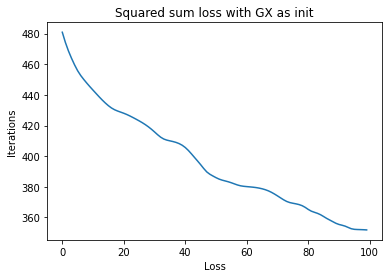

In [ ]:
'''
Trying with X' = G X initialization 
'''
start_time = time.time()
user_features_3 = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features_3 = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
combined_features = np.concatenate((user_features_3, movie_features_3), axis=0)
new_combined_features = adjacency_matrix @ combined_features
user_features_new_3 = new_combined_features[:n_users]
movie_features_new_3 = new_combined_features[n_users:]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_new_3 = torch.FloatTensor(user_features_new_3).to(device)
movie_features_new_3 = torch.FloatTensor(movie_features_new_3).to(device)
user_features_new_3.requires_grad = True
movie_features_new_3.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_new_3, movie_features_new_3], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_new_3, movie_features_new_3, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with GX as init')
plt.show()

In [ ]:
'''
Probabilistic connections + Graph alignment
'''
movie_user_probabilistic = movie_user_softmax
random_matrix = np.random.uniform(low=0, high=1, size=movie_user_probabilistic.shape)
connectivity_matrix_4 = ((random_matrix) < (k*movie_user_probabilistic)).astype(int)  

In [ ]:
# Forming a full N x N matrix from U x I matrix (full adjacency matrix)
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = connectivity_matrix_4
lower_left_matrix = np.transpose(connectivity_matrix_4)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix_4 = np.concatenate((upper_matrix, lower_matrix), axis=0)
predicted_graph_4 = nx.from_numpy_array(adjacency_matrix_4)

In [ ]:
# Finding the laplacian of the two graphs
sbm_g = find_laplacian(original_graph)
sbm_g1 = find_laplacian(predicted_graph_4)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)



[Epoch    1/600] loss: 9.271986 - std: 9.880778
[Epoch  100/600] loss: 6.780729 - std: 7.509479
[Epoch  200/600] loss: 6.505794 - std: 7.175537
[Epoch  300/600] loss: 6.223790 - std: 6.940368
[Epoch  400/600] loss: 6.370979 - std: 6.703661
[Epoch  500/600] loss: 6.644586 - std: 6.488757
[Epoch  600/600] loss: 6.125837 - std: 6.289528


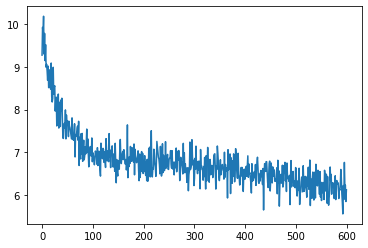

100%|██████████| 100/100 [00:00<00:00, 264.36it/s, loss=102.607]



Total time taken for 100 iterations is 15.023605585098267 (s)


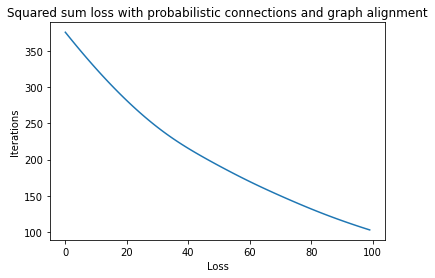

In [ ]:
# Aligning the two graphs
start_time = time.time()
sbm_G_inv, sbm_G1_inv, sbm_P = find_permutation(sbm_g, sbm_g1, it=10, tau=2, n_samples=k, epochs=graph_alignment_epochs, lr=0.5, 
                                               loss_type = 'w', alpha = 0.1, ones = True)

permutation = []
for i in range(sbm_P.shape[0]):
    for j in range(sbm_P.shape[1]):
        if sbm_P[i][j] == 1:
            permutation.append(j)

# Permuting the features assuming that movies and users are aligned among themselves and not across the two sets.
permuted_indices = permutation[0:n_users]
permuted_indices_shifted = [i%n_users for i in permuted_indices]
user_features_p = user_features[permuted_indices_shifted, :]
permuted_indices = permutation[n_users:n_users+n_movies]
permuted_indices_shifted = [i%n_movies for i in permuted_indices]
movie_features_p = movie_features[permuted_indices_shifted, :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_p = torch.FloatTensor(user_features_p).to(device)
movie_features_p = torch.FloatTensor(movie_features_p).to(device)
user_features_p.requires_grad = True
movie_features_p.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_p, movie_features_p], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_p, movie_features_p, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with probabilistic connections and graph alignment')
plt.show()

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

[Epoch    1/600] loss: 10.528123 - std: 9.749083
[Epoch  100/600] loss: 5.122251 - std: 5.816700
[Epoch  200/600] loss: 5.403133 - std: 5.291328
[Epoch  300/600] loss: 4.688044 - std: 4.921260
[Epoch  400/600] loss: 4.227290 - std: 4.631542
[Epoch  500/600] loss: 3.659485 - std: 4.411864
[Epoch  600/600] loss: 4.049073 - std: 4.207647


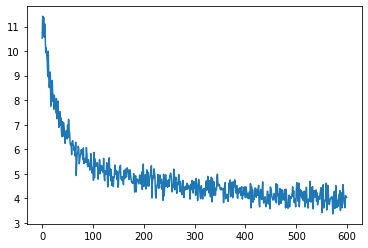

100%|██████████| 100/100 [00:00<00:00, 225.97it/s, loss=135.536]



Total time taken for 100 iterations is 15.770030736923218 (s)


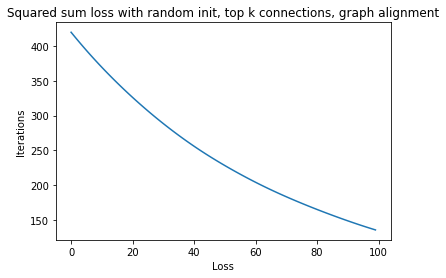

In [ ]:
'''
Hard max with random init
'''
user_features_4 = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features_4 = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
dot_prods = user_features_4 @ movie_features_4.T
connectivity_matrix_4 = np.zeros((n_users, n_movies))
for i in range(dot_prods.shape[0]):
  top_k_movies = np.argsort(dot_prods[i, :]).tolist()[-k:]
  for j in top_k_movies:
    connectivity_matrix_4[i][j] = 1
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = connectivity_matrix_4
lower_left_matrix = np.transpose(connectivity_matrix_4)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix_4 = np.concatenate((upper_matrix, lower_matrix), axis=0)
predicted_graph_4 = nx.from_numpy_array(adjacency_matrix_4)
start_time = time.time()
sbm_original = find_laplacian(original_graph)
sbm_predicted = find_laplacian(predicted_graph_4)
# Aligning the two graphs
start_time = time.time()
sbm_G_inv, sbm_G1_inv, sbm_P = find_permutation(sbm_original, sbm_predicted, it=10, tau=2, n_samples=k, epochs=graph_alignment_epochs, lr=0.5, 
                                               loss_type = 'w', alpha = 0.1, ones = True)

permutation = []
for i in range(sbm_P.shape[0]):
    for j in range(sbm_P.shape[1]):
        if sbm_P[i][j] == 1:
            permutation.append(j)

# Permuting the features assuming that movies and users are aligned among themselves and not across the two sets.
permuted_indices = permutation[0:n_users]
permuted_indices_shifted = [i%n_users for i in permuted_indices]
user_features_p = user_features_4[permuted_indices_shifted, :]
permuted_indices = permutation[n_users:n_users+n_movies]
permuted_indices_shifted = [i%n_movies for i in permuted_indices]
movie_features_p = movie_features_4[permuted_indices_shifted, :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_p = torch.FloatTensor(user_features_p).to(device)
movie_features_p = torch.FloatTensor(movie_features_p).to(device)
user_features_p.requires_grad = True
movie_features_p.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_p, movie_features_p], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_p, movie_features_p, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with random init, top k connections, graph alignment')
plt.show()

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

Number of isolated nodes 0
Length of graph 110

Shape of L1 is(110, 110)

Shape of L1 after densifying (110, 110)

Length of laplacian is (110, 110)

[Epoch    1/600] loss: 9.293588 - std: 9.904553
[Epoch  100/600] loss: 7.217420 - std: 7.944288
[Epoch  200/600] loss: 7.353312 - std: 7.665690
[Epoch  300/600] loss: 7.093978 - std: 7.448008
[Epoch  400/600] loss: 7.271831 - std: 7.217229
[Epoch  500/600] loss: 7.364205 - std: 6.994678
[Epoch  600/600] loss: 6.511068 - std: 6.788022


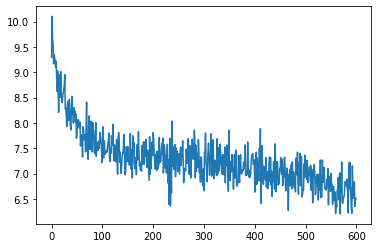

100%|██████████| 100/100 [00:00<00:00, 219.48it/s, loss=144.697]



Total time taken for 100 iterations is 15.526498079299927 (s)


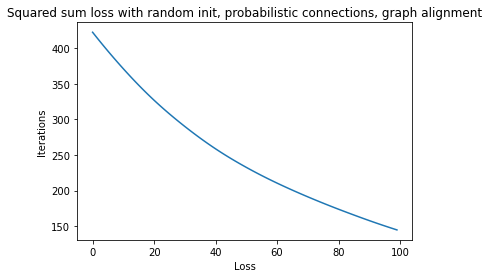

In [ ]:
'''
Probabilistic with random init
'''

user_features_5 = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features_5 = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
dot_prods = user_features_5 @ movie_features_5.T
exp_matrix = np.exp(dot_prods)
movie_user_softmax = exp_matrix/np.tile(np.reshape(np.sum(exp_matrix, axis=1), (n_users, 1)), (1, n_movies))
connectivity_matrix_5 = (np.random.uniform(low=0, high=1, size=movie_user_softmax.shape) < k*movie_user_softmax).astype(int)
upper_left_matrix = np.zeros((n_users, n_users))
upper_right_matrix = connectivity_matrix_5
lower_left_matrix = np.transpose(connectivity_matrix_5)
lower_right_matrix = np.zeros((n_movies, n_movies))
upper_matrix = np.concatenate((upper_left_matrix, upper_right_matrix), axis=1)
lower_matrix = np.concatenate((lower_left_matrix, lower_right_matrix), axis=1)
adjacency_matrix_5 = np.concatenate((upper_matrix, lower_matrix), axis=0)
predicted_graph_5 = nx.from_numpy_array(adjacency_matrix_5)
start_time = time.time()
sbm_original = find_laplacian(original_graph)
sbm_predicted = find_laplacian(predicted_graph_5)
# Aligning the two graphs
start_time = time.time()
sbm_G_inv, sbm_G1_inv, sbm_P = find_permutation(sbm_original, sbm_predicted, it=10, tau=2, n_samples=k, epochs=graph_alignment_epochs, lr=0.5, 
                                               loss_type = 'w', alpha = 0.1, ones = True)

permutation = []
for i in range(sbm_P.shape[0]):
    for j in range(sbm_P.shape[1]):
        if sbm_P[i][j] == 1:
            permutation.append(j)

# Permuting the features assuming that movies and users are aligned among themselves and not across the two sets.
permuted_indices = permutation[0:n_users]
permuted_indices_shifted = [i%n_users for i in permuted_indices]
user_features_p = user_features_5[permuted_indices_shifted, :]
permuted_indices = permutation[n_users:n_users+n_movies]
permuted_indices_shifted = [i%n_movies for i in permuted_indices]
movie_features_p = movie_features_5[permuted_indices_shifted, :]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#connectivity_matrix = torch.FloatTensor(connectivity_matrix).to(device)
non_zero_mask = (connectivity_matrix != -1)
user_features_p = torch.FloatTensor(user_features_p).to(device)
movie_features_p = torch.FloatTensor(movie_features_p).to(device)
user_features_p.requires_grad = True
movie_features_p.requires_grad = True
# Performing gradient descent on the original feature space after permuting it according to graph alignments
pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
optimizer = torch.optim.Adam([user_features_p, movie_features_p], lr=0.01)

bar = trange(num_epochs)
losses = []
for epoch in bar:
    optimizer.zero_grad()
    loss = pmferror(connectivity_matrix, user_features_p, movie_features_p, non_zero_mask)
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f'{loss:,.3f}')
    losses.append(loss)
end_time = time.time()
print("\nTotal time taken for", num_epochs, "iterations is", end_time - start_time,"(s)")
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Squared sum loss with random init, probabilistic connections, graph alignment')
plt.show()

In [ ]:
'''
Using Boxes for embeddings 
'''
random.seed(124)
np.random.seed(124)
torch.manual_seed(124)
# Initiating the features randomly
user_features = np.random.normal(loc=0, scale=1, size=(n_users, latent_vectors))
movie_features = np.random.normal(loc=0, scale=1, size=(n_movies, latent_vectors))
connectivity_matrix = np.zeros((n_users, n_movies))
# forming edges to the k closest movies 
for i in range(n_users):
  knn_indices = knnIndices(user_features[i], movie_features, k)
  for idx in knn_indices:
    connectivity_matrix[i, idx] = 1
print("Shape of conncectivty_matirx is", connectivity_matrix.shape)

Shape of conncectivty_matirx is (100, 40)


# New Section

In [ ]:
start_time = time.time()
directed_edges = []
B = nx.DiGraph()
for i in range(connectivity_matrix.shape[0]):
  for j in range(connectivity_matrix.shape[1]):
    if connectivity_matrix[i][j] == 1:
      directed_edges.append((i, j + n_users))
B.add_nodes_from([i for i in range(n_users)], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from([i + n_users for i in range(n_movies)], bipartite=1)
B.add_edges_from(directed_edges)

for j in range(n_movies):
  isConnected = False
  for i in range(n_users):
    if connectivity_matrix[i][j] == 1:
      isConnected = True
      break
  if isConnected == False:
    B.add_edge((0, n_users + j))

total_order = [i for i in range(n_users + n_movies)]
U = nx.Graph(B)
boxes, boxicity = generate_intersection_box(U, average_degree=True)
if boxes is None:
    print('fail')
else:
    print('boxicity success!')
    print(boxes.shape)

cond_boxes, threshold, B_box, Cond_Prob_box, Cond_Prob = introduce_additional_dimension(B, boxes, total_order)
end_time = time.time()

using maximum degree as Delta
N=140, Delta=28.571428571428573, dim=152
difference(U_, U) [(105, 121), (105, 130), (120, 130), (121, 138), (127, 130)]
difference(U, U_) []
difference(U_, U) [(111, 123), (116, 122), (116, 136), (123, 136)]
difference(U, U_) []
difference(U_, U) [(107, 131)]
difference(U, U_) []
difference(U_, U) [(102, 130), (103, 130)]
difference(U, U_) []
difference(U_, U) [(107, 114)]
difference(U, U_) []
difference(U_, U) [(112, 120), (112, 123), (120, 123), (130, 139)]
difference(U, U_) []
difference(U_, U) [(114, 133), (123, 129), (123, 133)]
difference(U, U_) []
boxicity success!
(140, 152, 2)


In [ ]:
end_time- start_time

68.43599462509155

In [ ]:
def mAP(Cond_Prob, connectivity_matrix, k):
  total1 = 0
  for i in range(n_users):
    a = Cond_Prob[i]
    a[i] = 0
    b = np.argsort(-a)
    total2 = 0
    for j in range(1, k+1):
      correct_preds = 0
      for z in range(j):
        if b[z] >= n_users and connectivity_matrix[i][b[z] - n_users] == 1:
          correct_preds += 1
      total2 += correct_preds/j
    total2 /= k
    total1 += total2
  total1 /= n_users
  return total1

In [ ]:
print(mAP(Cond_Prob, connectivity_matrix, k))

1.0


In [ ]:
end_time - start_time

68.43599462509155

Time taken for generating box embeddings: 32.0322482585907
[(0, 100), (0, 103), (0, 106), (0, 107), (0, 109), (1, 101), (1, 102), (1, 103), (1, 107), (1, 109), (2, 101), (2, 103), (2, 107), (2, 108), (2, 109), (3, 100), (3, 102), (3, 103), (3, 108), (3, 109), (4, 100), (4, 103), (4, 106), (4, 107), (4, 108), (5, 100), (5, 101), (5, 103), (5, 106), (5, 108), (6, 100), (6, 102), (6, 103), (6, 106), (6, 109), (7, 100), (7, 102), (7, 103), (7, 107), (7, 109), (8, 100), (8, 102), (8, 103), (8, 105), (8, 109), (9, 100), (9, 103), (9, 106), (9, 107), (9, 108), (10, 101), (10, 102), (10, 103), (10, 105), (10, 108), (11, 102), (11, 103), (11, 105), (11, 107), (11, 108), (12, 100), (12, 103), (12, 107), (12, 108), (12, 109), (13, 100), (13, 104), (13, 106), (13, 108), (13, 109), (14, 100), (14, 101), (14, 103), (14, 106), (14, 107), (15, 100), (15, 101), (15, 103), (15, 104), (15, 108), (16, 100), (16, 101), (16, 103), (16, 108), (16, 109), (17, 100), (17, 101), (17, 103), (17, 107), (17, 109), 

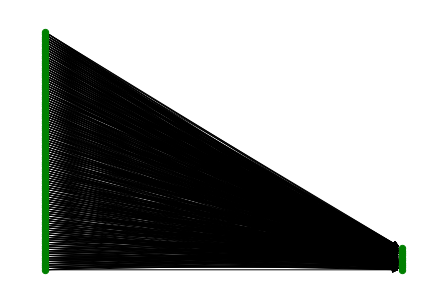

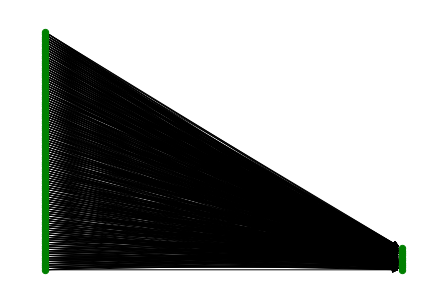

In [ ]:
print("Time taken for generating box embeddings: " + str(end_time - start_time))
# cond_boxes: generated boxes
# threshold
# D_box: graph generated by cond_boxes and threshold
# Cond_prob_box: conditional probability matrix from cond_boxes P(row|column)
# Cond_prob: conditional probability from step 1 (boxicity)
print(B_box.edges())
print(B.edges())
print('box generated ? ', nx.is_isomorphic(B_box, B))
#print('P=',Prob_box)
print('threshold', threshold)

l, r = nx.bipartite.sets(B)
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(B, pos=pos, arrowsize=12, node_size=40,node_color='green')
plt.show()

nx.draw(B_box, pos=pos, arrowsize=12, node_size=40,node_color='green')
plt.show()